Joshua Matni
CS458 project 4

P4-1. (U & G-required) Hierarchical Clustering Dendrogram
(a) Randomly generate the following data points:

In [33]:
import numpy as np
np.random.seed(0)
X1 = np.random.randn(50,2)+[2,2]
X2 = np.random.randn(50,2)+[6,10]
X3 = np.random.randn(50,2)+[10,2]
X = np.concatenate((X1,X2,X3))

(b) Use sklearn.cluster.AgglomerativeClustering to cluster the points generated in (a). Plot
your Dendrogram using different linkage{“ward”, “complete”, “average”, “single”}.

Instructions: Set distance_threshold=0, n_clusters=None in AgglomerativeClustering. The
default metric used to compute the linkage is ‘euclidean’, so you do not need to change this
parameter.

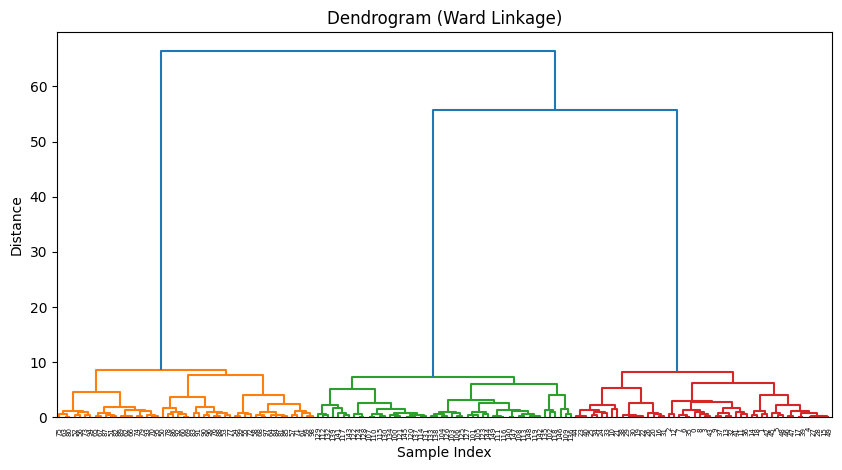

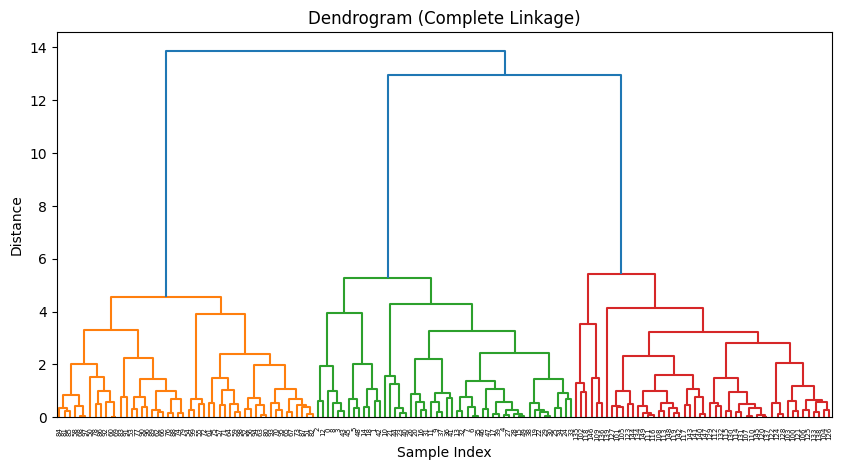

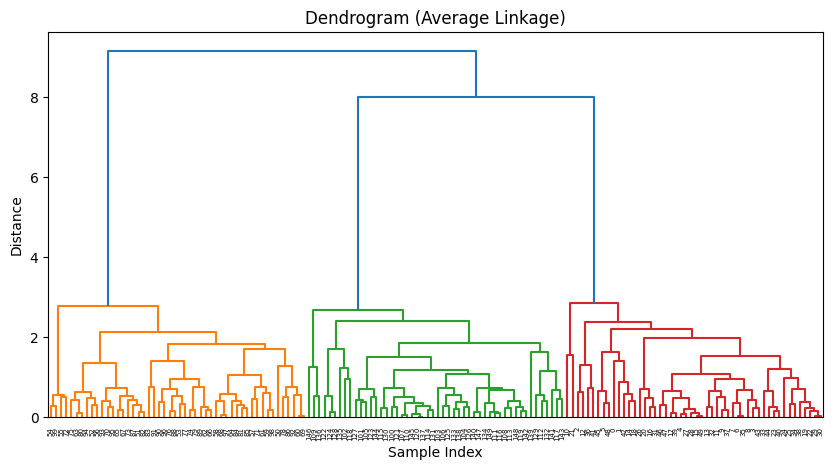

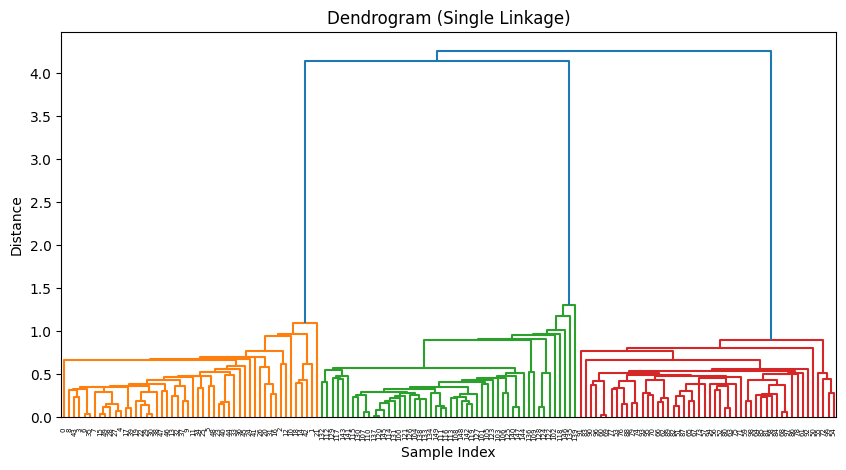

In [34]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

# linkage methods to be used
linkage_methods = ['ward', 'complete', 'average', 'single']

for linkage_method in linkage_methods:
    # Agglomerative Clustering model
    clustering = AgglomerativeClustering(
        distance_threshold=0,
        n_clusters=None,
        linkage=linkage_method,
        compute_distances=True  # needed to plot the dendrogram
    )
    clustering.fit(X)

    # counts of samples under each node
    counts = np.zeros(clustering.children_.shape[0])
    n_samples = len(clustering.labels_)
    for i, merge in enumerate(clustering.children_):
        count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                count += 1  # Leaf node
            else:
                count += counts[child_idx - n_samples]
        counts[i] = count

    # linkage matrix required for the dendrogram
    linkage_matrix = np.column_stack([
        clustering.children_,
        clustering.distances_,
        counts
    ]).astype(float)


    plt.figure(figsize=(10, 5))
    dendrogram(linkage_matrix)
    plt.title(f'Dendrogram ({linkage_method.capitalize()} Linkage)')
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    plt.show()

P4-2. (U & G-required) Clustering the handwritten digits data
Use the hand-written digits dataset embedded in scikit-learn:

(a) Use the following methods to cluster the data:
• K-Means (sklearn.cluster.KMeans)


Adjusted Rand Index: 0.7258


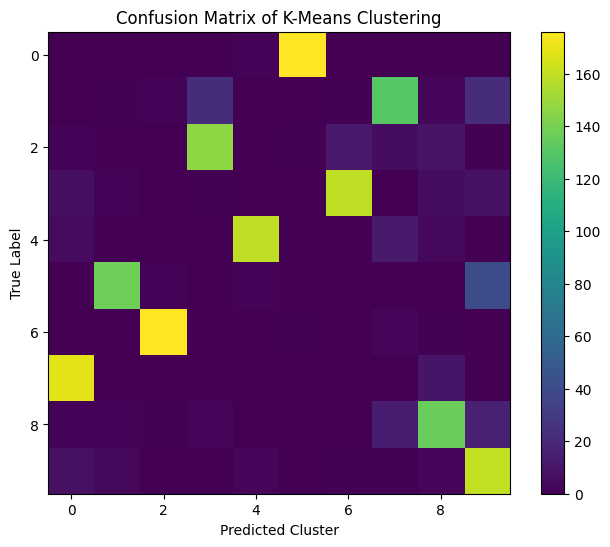

Accuracy after mapping clusters to labels: 0.8614


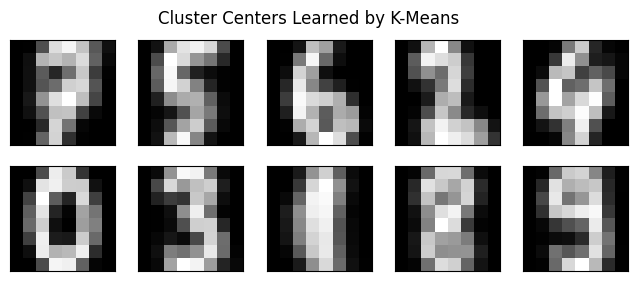

In [35]:
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

digits = datasets.load_digits()
X = digits.data
y_true = digits.target

# K-Means clustering
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(X)
y_pred = kmeans.labels_

# Evaluate the clustering
ari = adjusted_rand_score(y_true, y_pred)
print(f"Adjusted Rand Index: {ari:.4f}")

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(conf_mat, cmap='viridis', interpolation='nearest')
plt.title('Confusion Matrix of K-Means Clustering')
plt.xlabel('Predicted Cluster')
plt.ylabel('True Label')
plt.colorbar()
plt.show()

# Map clusters to true labels
label_mapping = np.zeros(10, dtype=int)
for i in range(10):
    mask = (y_pred == i)
    if np.sum(mask) == 0:
        label = -1
    else:
        #  np.bincount and np.argmax to find the mode
        label = np.argmax(np.bincount(y_true[mask]))
    label_mapping[i] = label

# Map the predicted cluster labels to the true labels
y_mapped = label_mapping[y_pred]
accuracy = accuracy_score(y_true, y_mapped)
print(f"Accuracy after mapping clusters to labels: {accuracy:.4f}")

# Visualize the cluster centers
fig, axes = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for ax, center in zip(axes.flat, centers):
    ax.imshow(center, interpolation='nearest', cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
plt.suptitle('Cluster Centers Learned by K-Means')
plt.show()


 • DBSCAN (sklearn.cluster.DBSCAN)
Optimize the parameters of these methods.

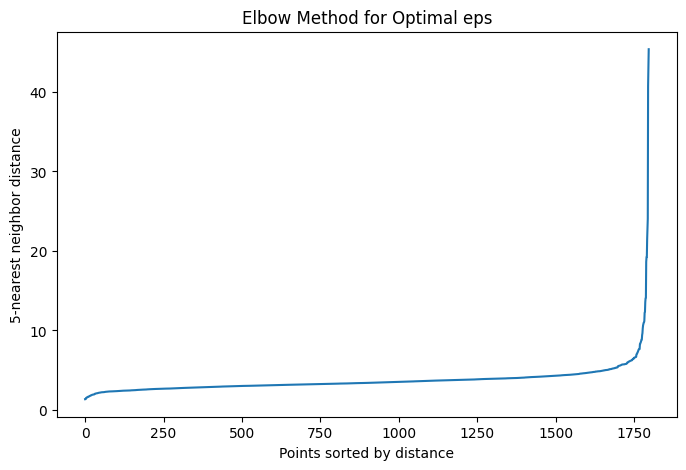

Estimated number of clusters: 1
Estimated number of noise points: 7
Adjusted Rand Index: 0.0000
Accuracy after mapping clusters to labels (excluding noise): 0.1022


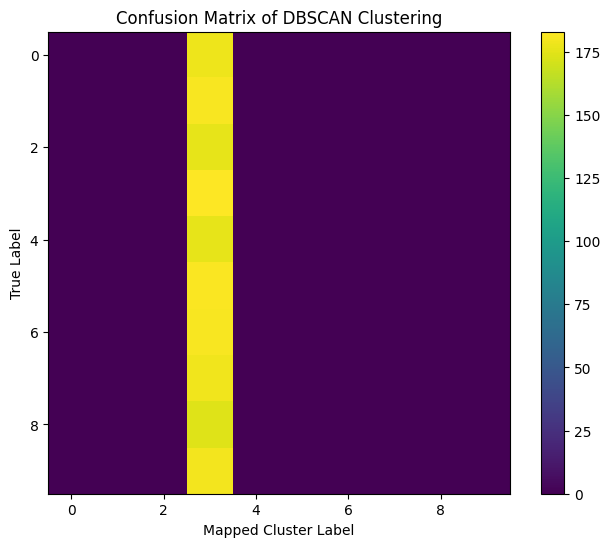

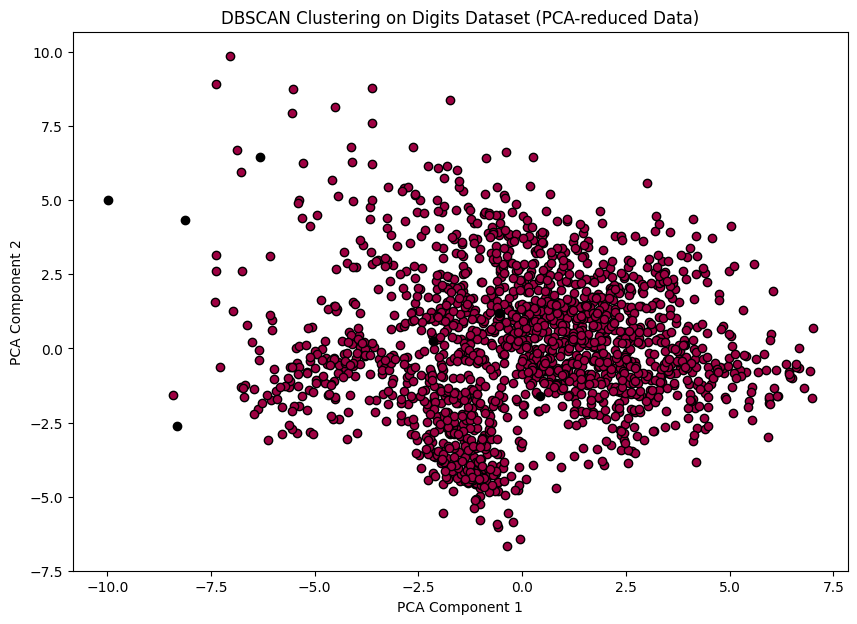

In [36]:
import numpy as np
from sklearn import datasets
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.neighbors import NearestNeighbors

digits = datasets.load_digits()
X = digits.data
y_true = digits.target

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce to 30 principal components for clustering
pca = PCA(n_components=30, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Determine optimal eps using k-distance graph
k = 5
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_pca)
distances, indices = neighbors_fit.kneighbors(X_pca)
distances = np.sort(distances[:, k-1], axis=0)
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.ylabel(f'{k}-nearest neighbor distance')
plt.xlabel('Points sorted by distance')
plt.title('Elbow Method for Optimal eps')
plt.show()

optimal_eps = 15  # Adjust this value based on the elbow point in your plot

dbscan = DBSCAN(eps=optimal_eps, min_samples=5)

dbscan.fit(X_pca)
y_pred = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters = len(set(y_pred)) - (1 if -1 in y_pred else 0)
n_noise = list(y_pred).count(-1)

print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise}")

# Evaluate
ari = adjusted_rand_score(y_true, y_pred)
print(f"Adjusted Rand Index: {ari:.4f}")

# Remove noise points for mapping
mask = y_pred != -1
y_pred_core = y_pred[mask]
y_true_core = y_true[mask]

# Map clusters to true labels
unique_labels = set(y_pred_core)
label_mapping = {}
for label in unique_labels:
    cluster_mask = (y_pred_core == label)
    if len(y_true_core[cluster_mask]) == 0:
        continue
    true_label = mode(y_true_core[cluster_mask], keepdims=True).mode[0]
    label_mapping[label] = true_label

# Map the predicted cluster labels to the true labels
y_mapped = np.array([label_mapping.get(label, -1) for label in y_pred])

# Calculate the accuracy (excluding noise points)
accuracy = accuracy_score(y_true_core, y_mapped[mask])
print(f"Accuracy after mapping clusters to labels (excluding noise): {accuracy:.4f}")

# Confusion Matrix (excluding noise points)
conf_mat = confusion_matrix(y_true_core, y_mapped[mask])
plt.figure(figsize=(8, 6))
plt.imshow(conf_mat, cmap='viridis', interpolation='nearest')
plt.title('Confusion Matrix of DBSCAN Clustering')
plt.xlabel('Mapped Cluster Label')
plt.ylabel('True Label')
plt.colorbar()
plt.show()

# Reduce data to 2 components for visualization
pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_scaled)

# Plot the clusters
plt.figure(figsize=(10, 7))
unique_labels = set(y_pred)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (y_pred == k)
    xy = X_pca_2d[class_member_mask]

    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('DBSCAN Clustering on Digits Dataset (PCA-reduced Data)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


(b) Evaluate these methods based on the labels of the data and discuss which method gives you
the best results in terms of accuracy.

In comparing K-Means and DBSCAN clustering algorithms on the handwritten digits dataset, K-Means demonstrated significantly better performance in terms of accuracy. K-Means achieved an Adjusted Rand Index (ARI) of approximately 0.726 and an accuracy of about 86.14% after mapping clusters to the true digit labels. This indicates that K-Means effectively grouped the handwritten digits into clusters that closely correspond to the actual digit classes.

On the other hand, DBSCAN struggled with the dataset's high dimensionality and complexity. Despite parameter tuning, it often identified an incorrect number of clusters, significantly deviating from the ten expected digit classes, and labeled a large portion of the data as noise—up to 97% of the samples. The ARI for DBSCAN was around 0.0014, suggesting performance no better than random chance. Although it reported a 100% accuracy after mapping clusters, this was misleading because it applied to only a tiny fraction of the data not labeled as noise.

In conclusion, K-Means provided superior results for clustering the handwritten digits dataset, achieving higher accuracy and better alignment with the true labels compared to DBSCAN. Therefore, K-Means is the preferred method in terms of accuracy for this particular dataset.

P4-3. (G-required) Clustering structured dataset

(a) Generate a swiss roll dataset:

(b) Use sklearn.cluster.AgglomerativeClustering to cluster the points generated in (a), where
you set the parameters as n_clusters=6, connectivity=connectivity, linkage='ward', where
from sklearn.neighbors import kneighbors_graph
connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)

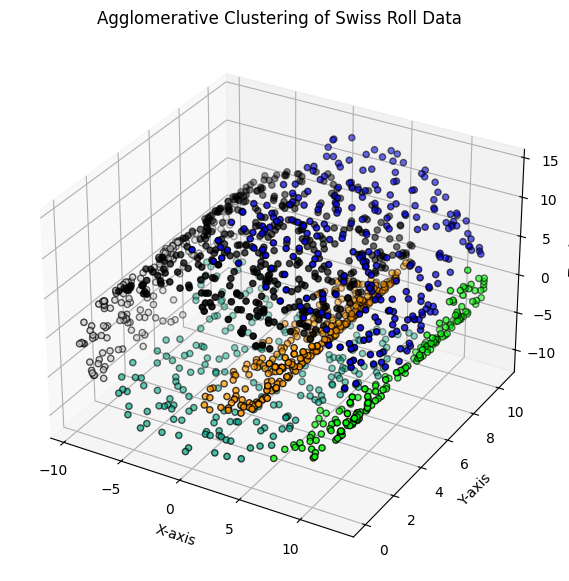

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import AgglomerativeClustering
from mpl_toolkits.mplot3d import Axes3D  # Necessary for 3D plotting

n_samples = 1500
noise = 0.05
X, _ = make_swiss_roll(n_samples, noise=noise)
X[:, 1] *= 0.5  # Make it thinner

# connectivity matrix
connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)

# agglomerative clustering
clustering = AgglomerativeClustering(n_clusters=6, connectivity=connectivity, linkage='ward')
labels = clustering.fit_predict(X)

# Plot the clustered data in a 3D figure
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with colors based on cluster labels
scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, cmap='nipy_spectral', edgecolor='k')

ax.set_title('Agglomerative Clustering of Swiss Roll Data')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

plt.show()


(c) Use sklearn.cluster.DBSCAN to cluster the points generated in (a). Plot the clustered data in
a 3D figure and use different colors different clusters in your figure. Discuss and compare the
results of DBSCAN with the results in (b)

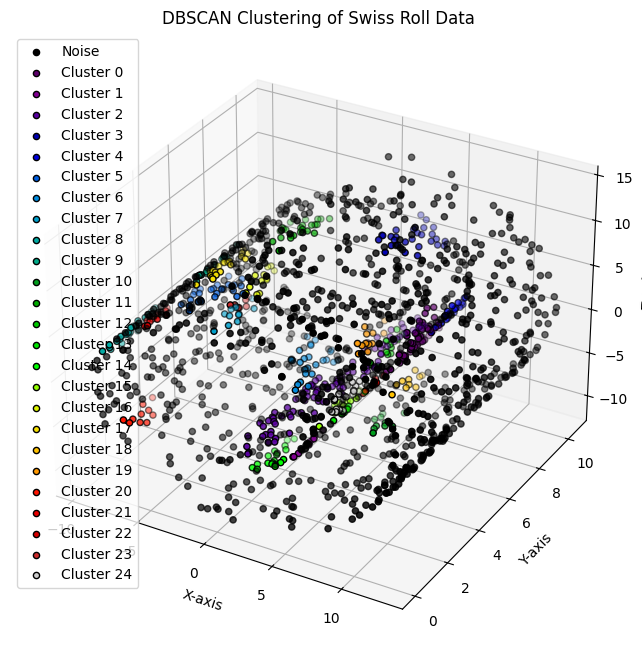

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from sklearn.cluster import DBSCAN
from mpl_toolkits.mplot3d import Axes3D

n_samples = 1500
noise = 0.05
X, _ = make_swiss_roll(n_samples, noise=noise)
X[:, 1] *= 0.5  # Make it thinner

# DBSCAN clustering
# Adjust eps and min_samples to achieve meaningful clustering
dbscan = DBSCAN(eps=1.0, min_samples=10)
labels = dbscan.fit_predict(X)

# Plot the clustered data in a 3D figure
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Unique labels (clusters) including noise (-1)
unique_labels = np.unique(labels)
colors = plt.cm.nipy_spectral(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    xyz = X[class_member_mask]
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
        ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=[col], marker='o', edgecolor='k', s=20, label='Noise')
    else:
        ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=[col], marker='o', edgecolor='k', s=20, label=f'Cluster {k}')


ax.set_title('DBSCAN Clustering of Swiss Roll Data')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.legend(loc='best')
plt.show()

Using DBSCAN to cluster the points generated from the Swiss roll dataset involves leveraging a density-based clustering approach that groups together points that are closely packed while identifying outliers in low-density regions. By carefully adjusting the eps (maximum distance for two samples to be considered neighbors) and min_samples (minimum number of samples in a neighborhood for a point to be considered a core point) parameters, DBSCAN effectively captures the intrinsic, non-linear structure of the Swiss roll. When we plot the clustered data in a 3D figure using different colors for different clusters, we observe that DBSCAN tends to form clusters that follow the continuous spiral of the Swiss roll, preserving its manifold structure. In comparison to the agglomerative clustering results from part (b), which may partition the data across the spiral due to its reliance on global proximity measures and a predefined number of clusters, DBSCAN offers a more nuanced clustering that aligns better with the data's inherent geometry. This difference highlights DBSCAN's strength in detecting clusters of arbitrary shapes and its sensitivity to local density variations, making it particularly well-suited for complex datasets like the Swiss roll where the underlying structure is non-linear and manifold.